In this data set i have done:

EDA (distributions, heatmap, missing values).

Cluster Evaluation (all 3 metrics + elbow).

Dimensionality Reduction (PCA, t-SNE).

Cluster Profiling (summary tables + categorical distributions).

Comparison with Hierarchical & DBSCAN.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('cofee_health.csv')

In [3]:
df.isnull().sum()

ID                         0
Age                        0
Gender                     0
Country                    0
Coffee_Intake              0
Caffeine_mg                0
Sleep_Hours                0
Sleep_Quality              0
BMI                        0
Heart_Rate                 0
Stress_Level               0
Physical_Activity_Hours    0
Health_Issues              0
Occupation                 0
Smoking                    0
Alcohol_Consumption        0
dtype: int64

### 1. Exploratory Data Analysis (EDA)

In [4]:
# 1.2 Distribution plots
numeric_cols = ['Age','Coffee_Intake','Caffeine_mg','Sleep_Hours','BMI','Heart_Rate','Physical_Activity_Hours']

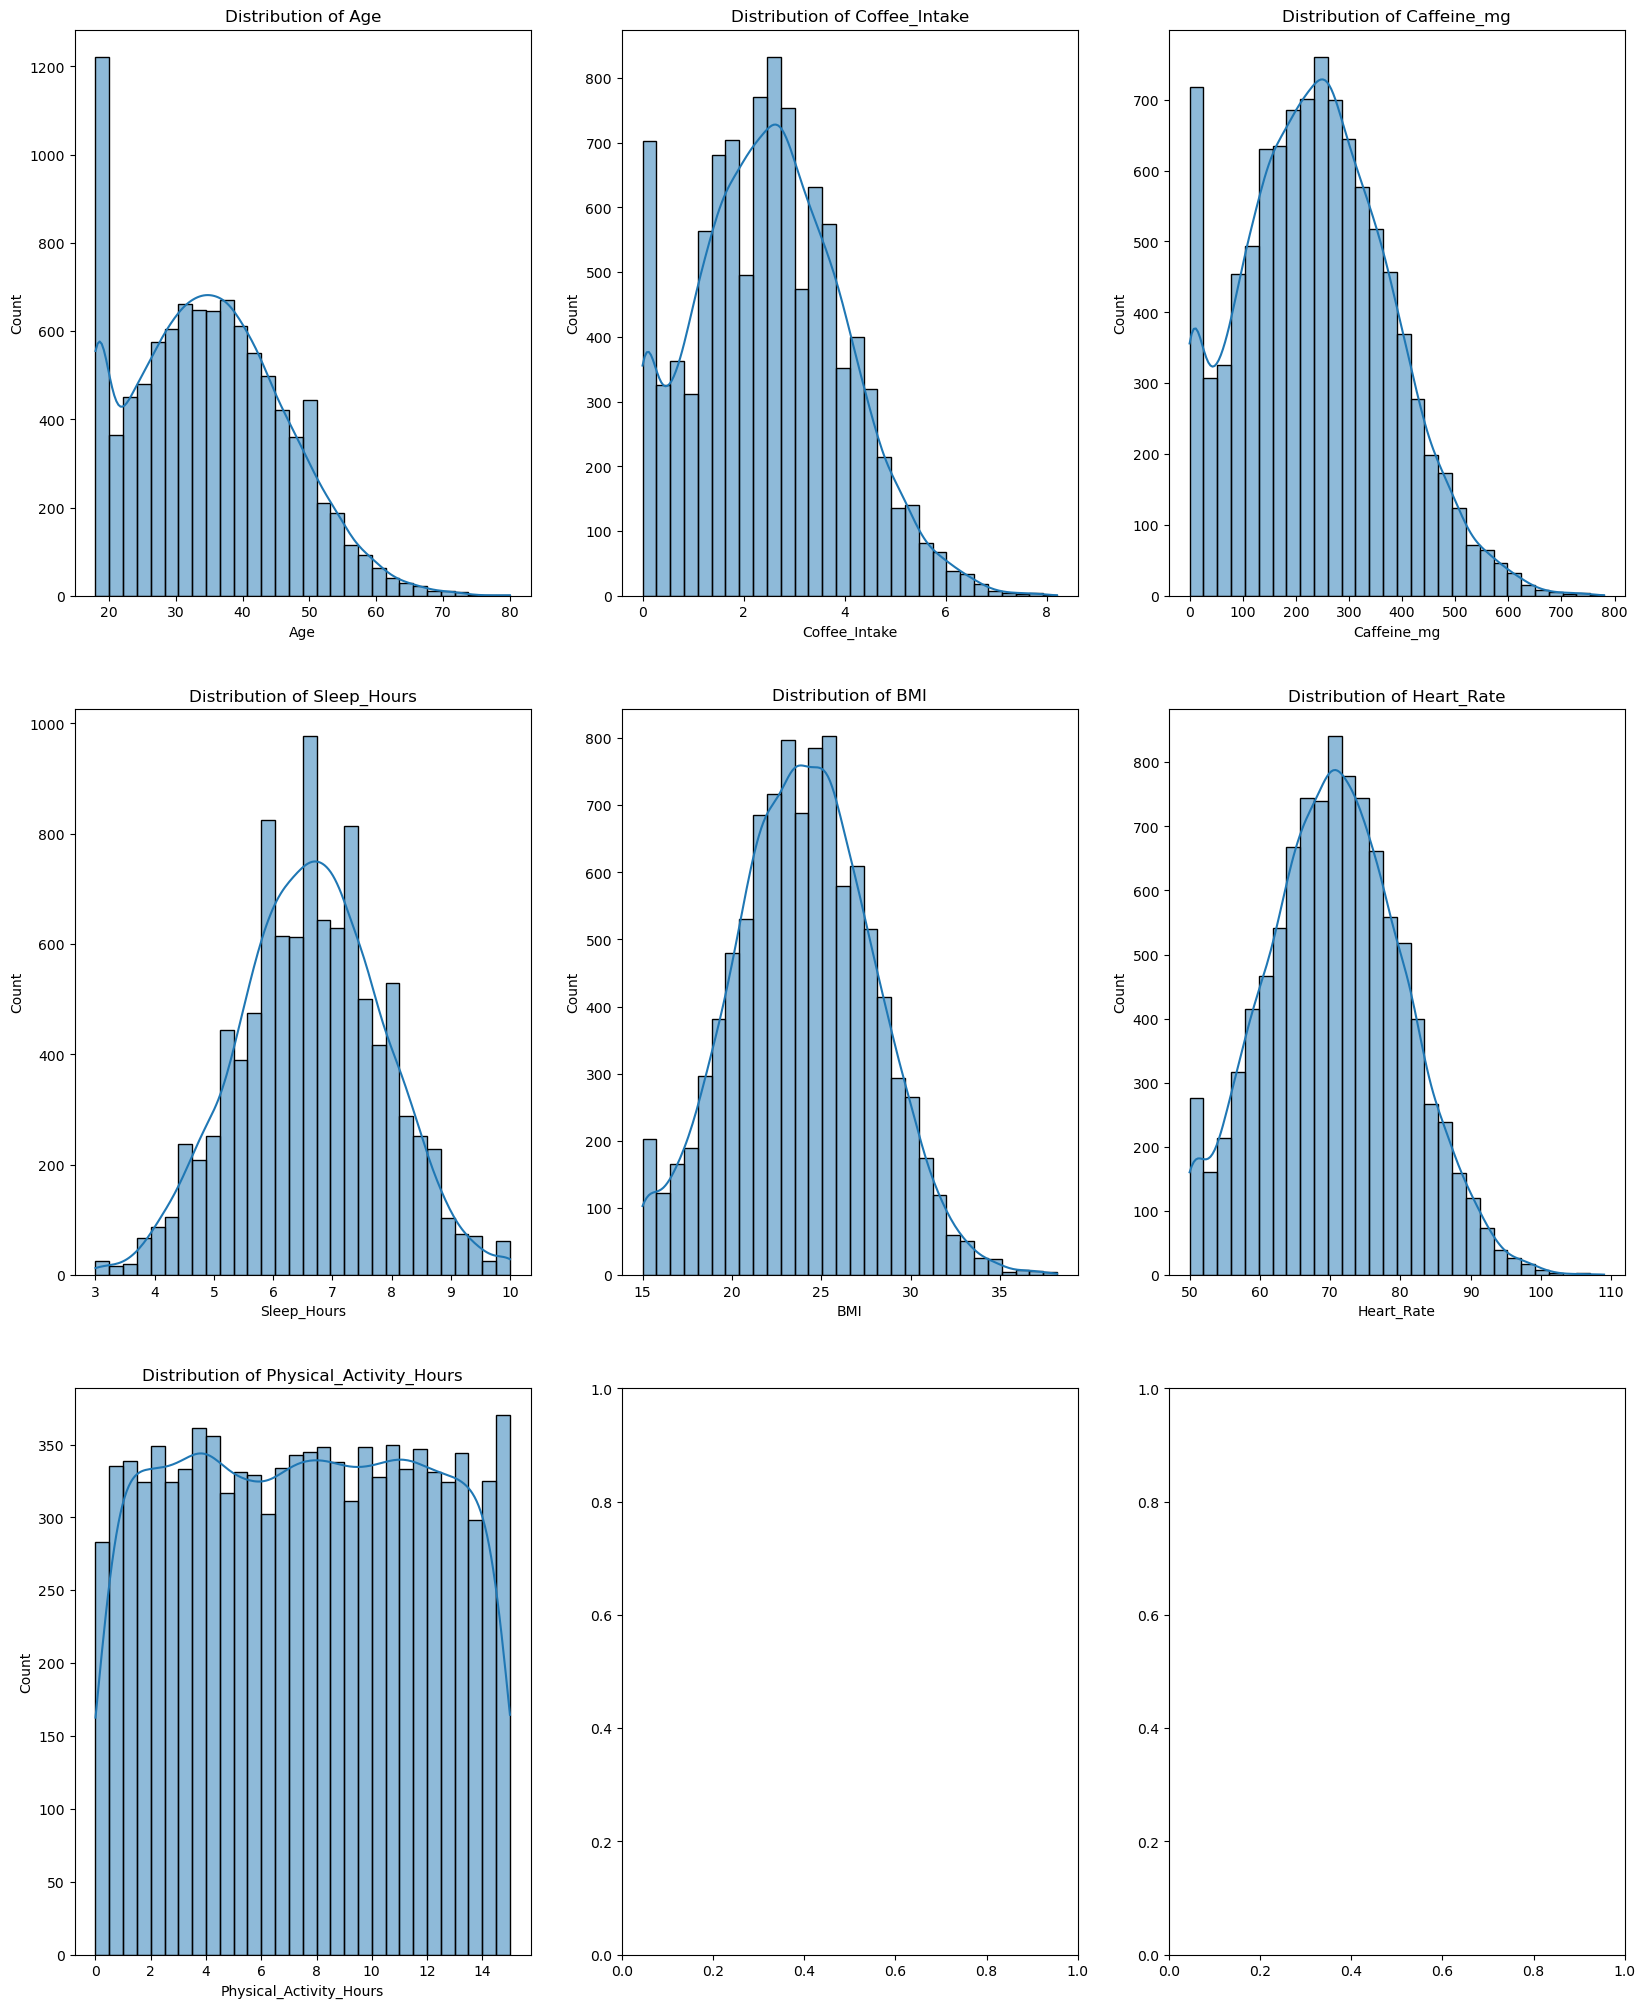

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))
axes = axes.flatten()  # Flatten 2D axes into 1D for easy indexing

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

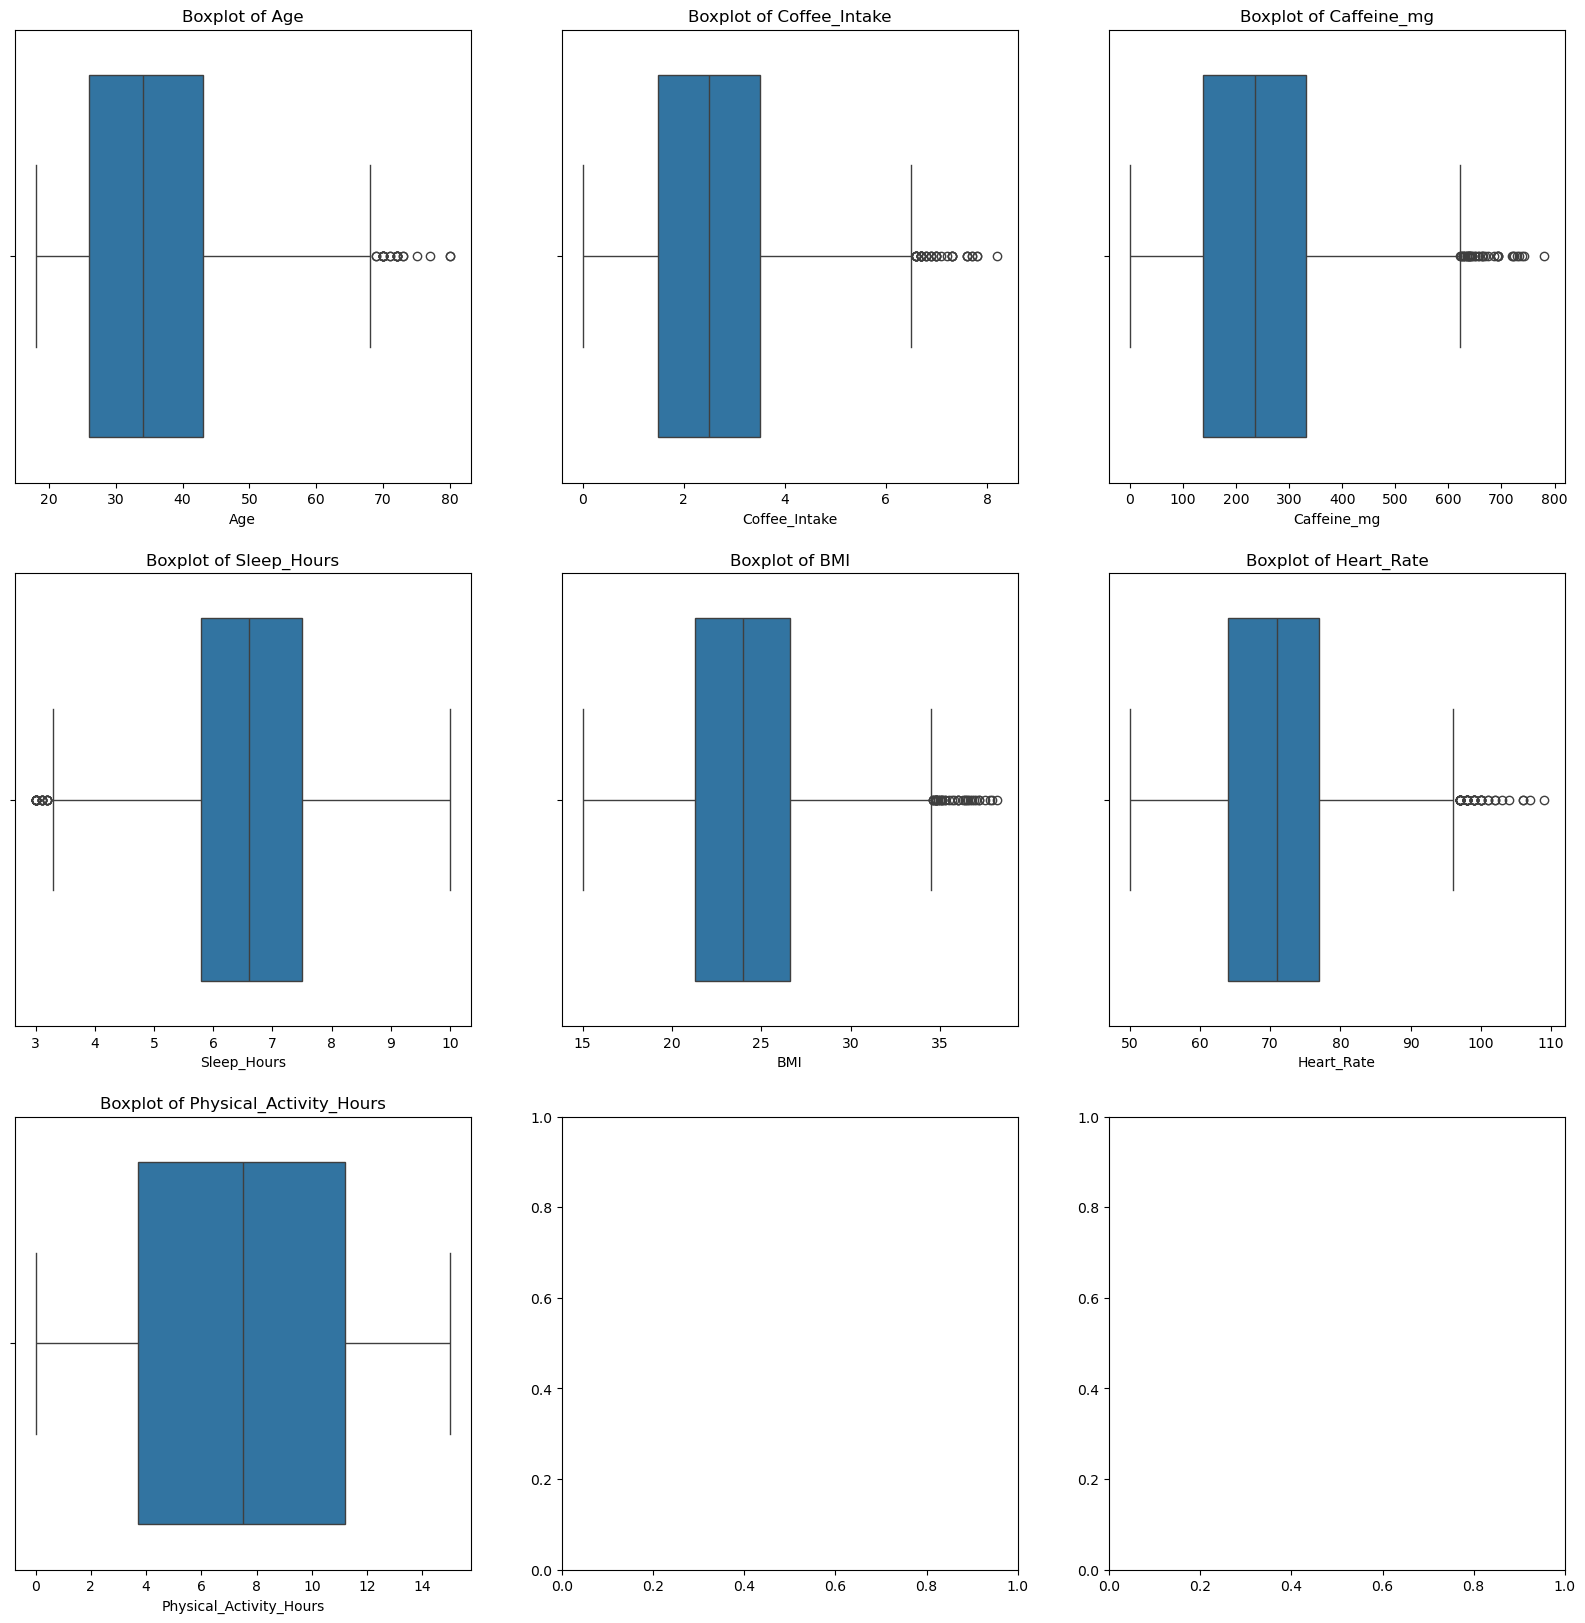

In [6]:
# 1.3 Boxplots for outlier detection
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")


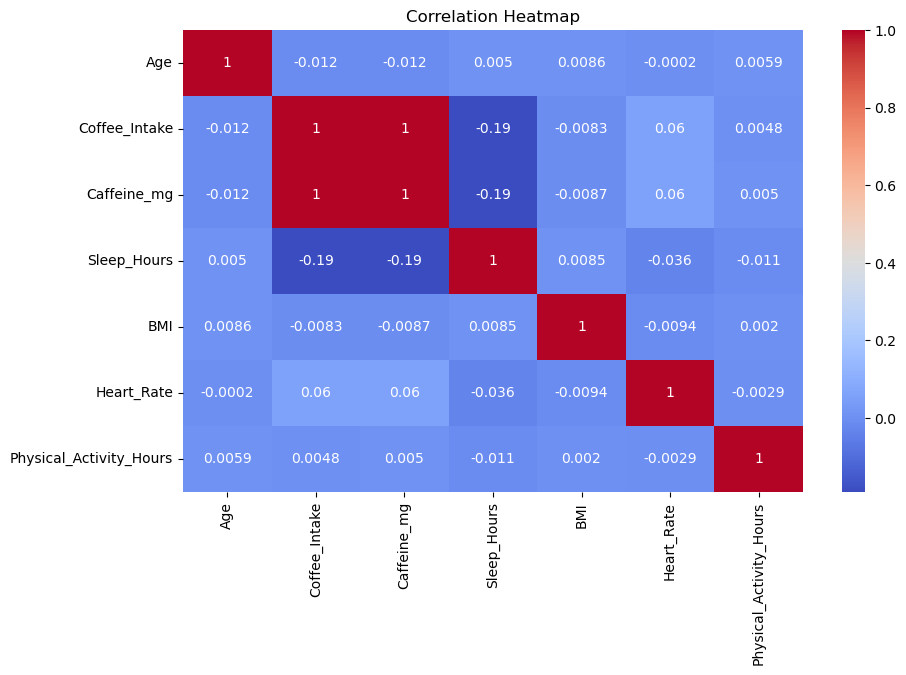

In [7]:
# 1.4 Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


### 2. Cluster Evaluation

In [8]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

In [9]:
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Health_Issues', 'Occupation']
df_encoded = df.copy()
for col in categorical_cols:
    encoded = LabelEncoder().fit_transform(df_encoded[col])
    df_encoded[col + '_encoded'] = encoded


In [10]:
features = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI',
            'Heart_Rate', 'Physical_Activity_Hours', 'Smoking', 'Alcohol_Consumption',
            'Gender_encoded', 'Sleep_Quality_encoded', 'Stress_Level_encoded',
            'Health_Issues_encoded', 'Occupation_encoded']
X = df_encoded[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []
K = range(2,11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

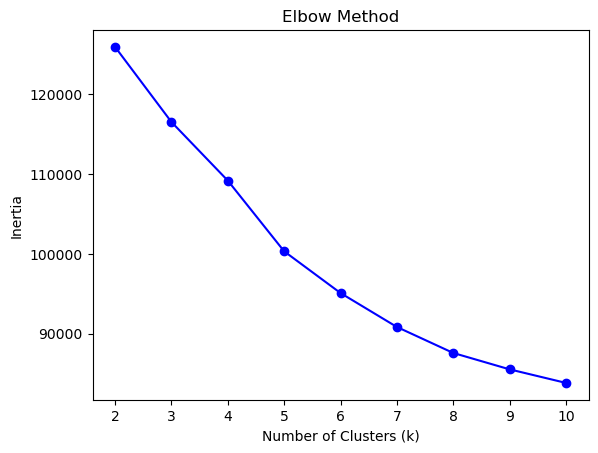

In [12]:
# Elbow Method
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

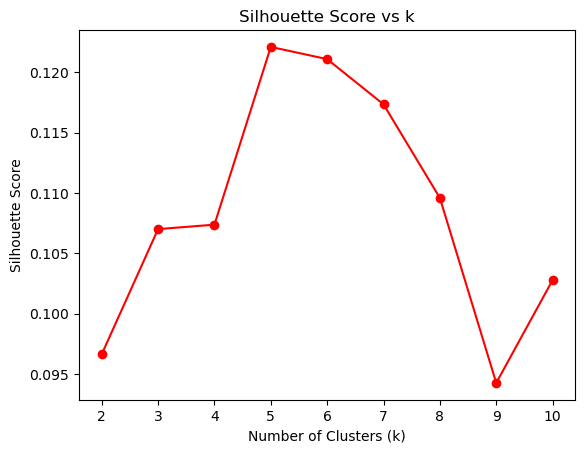

In [13]:
# Silhouette Score
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.show()

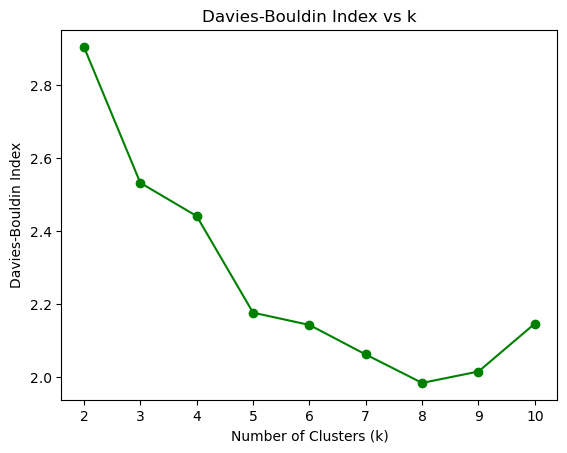

In [14]:
# Davies-Bouldin Index (lower = better)
plt.plot(K, db_scores, 'go-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs k")
plt.show()

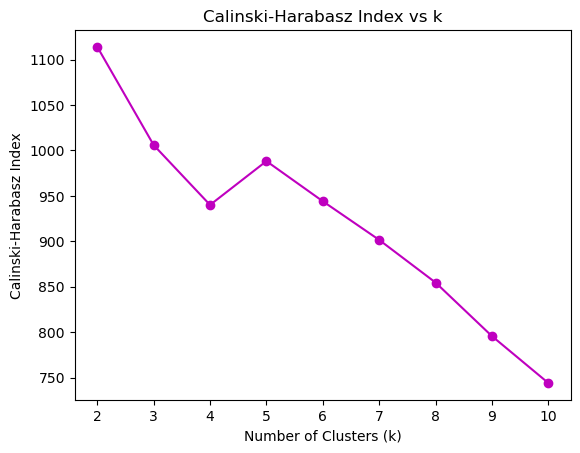

In [15]:
# Calinski-Harabasz Index (higher = better)
plt.plot(K, ch_scores, 'mo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski-Harabasz Index")
plt.title("Calinski-Harabasz Index vs k")
plt.show()


### 3. Dimensionality Reduction

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
# PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [18]:
kmeans_pca = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

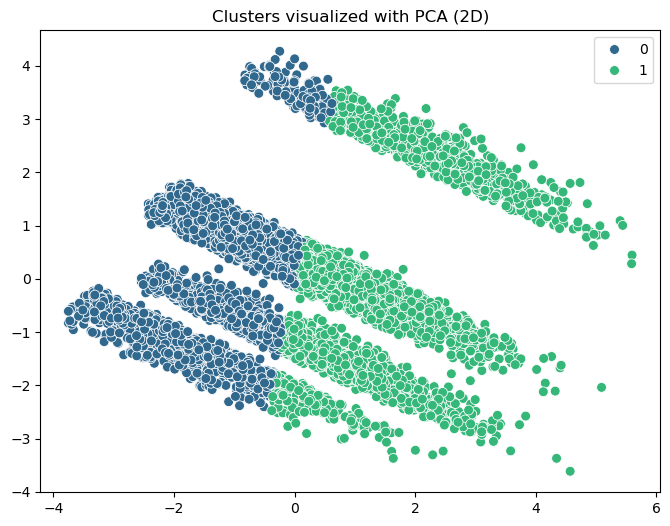

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_pca, palette="viridis", s=50)
plt.title("Clusters visualized with PCA (2D)")
plt.show()


In [20]:
# t-SNE 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_pca)

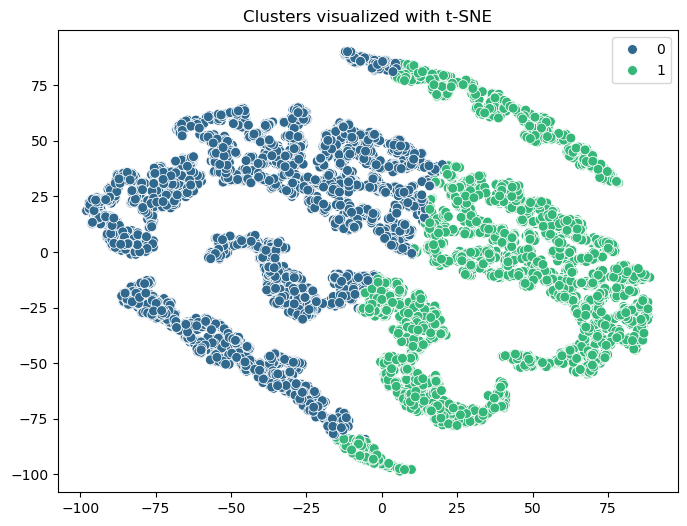

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_pca, palette="viridis", s=50)
plt.title("Clusters visualized with t-SNE")
plt.show()


### 4. Cluster Profiling

In [22]:
# Add cluster labels from best KMeans
df['Cluster'] = labels_pca 

In [23]:
# Summary statistics per cluster
cluster_profile = df.groupby('Cluster')[['BMI','Coffee_Intake','Caffeine_mg','Sleep_Hours','Heart_Rate','Physical_Activity_Hours']].mean()
cluster_profile

,BMI,Coffee_Intake,Caffeine_mg,Sleep_Hours,Heart_Rate,Physical_Activity_Hours
Cluster,,,,,,
0,23.996139,1.411544,134.150745,7.062975,69.777538,7.426068
1,23.977195,3.652634,347.013679,6.191690,71.493058,7.550551


In [24]:
print("Cluster distribution for 'Stress_Level'")
pd.DataFrame(df.groupby('Cluster')['Stress_Level'].value_counts(normalize=True))

Cluster distribution for 'Stress_Level'


proportion
Cluster Stress_Level            
0       Low             0.808702
        Medium          0.161505
        High            0.029792
1       Low             0.584524
        Medium          0.250306
        High            0.165169

In [25]:
print("Cluster distribution for 'Sleep_Quality'")
pd.DataFrame(df.groupby('Cluster')['Sleep_Quality'].value_counts(normalize=True))

Cluster distribution for 'Sleep_Quality'


proportion
Cluster Sleep_Quality            
0       Good             0.586829
        Excellent        0.221874
        Fair             0.161505
        Poor             0.029792
1       Good             0.539608
        Fair             0.250306
        Poor             0.165169
        Excellent        0.044916

In [26]:
print("Cluster distribution for 'Health_Issues'")
pd.DataFrame(df.groupby('Cluster')['Health_Issues'].value_counts(normalize=True))

Cluster distribution for 'Health_Issues'


proportion
Cluster Health_Issues            
0       Mild             0.977656
        Moderate         0.021560
        Severe           0.000784
1       Mild             0.925276
        Moderate         0.072070
        Severe           0.002654

### 5. Comparison with Other Algorithms

In [27]:
scores= silhouette_score(X_pca, labels_pca)
print("KMeans Silhouette Scores:", scores)

KMeans Silhouette Scores: 0.3470846652695597


In [30]:
kmeans_tsne = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_tsne = kmeans_pca.fit_predict(X_tsne,)
scores1= silhouette_score(X_tsne, labels_tsne)
print("KMeans Silhouette Scores:", scores1)

KMeans Silhouette Scores: 0.36730918


In [33]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [34]:
# Hierarchical Clustering
hier = AgglomerativeClustering(n_clusters=4)
labels_hier = hier.fit_predict(X_pca)
print("Silhouette Score (Hierarchical):", silhouette_score(X_pca, labels_hier))

Silhouette Score (Hierarchical): 0.38717402013951785


In [35]:
# DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
labels_db = dbscan.fit_predict(X_pca)

In [36]:
# Filter out noise (-1)
mask = labels_db != -1
if len(set(labels_db[mask])) > 1:  # ensure at least 2 clusters
    sil_dbscan = silhouette_score(X_scaled[mask], labels_db[mask])
    print("Silhouette Score (DBSCAN):", sil_dbscan)
else:
    print("Silhouette Score (DBSCAN): Not applicable (all noise or 1 cluster)")

Silhouette Score (DBSCAN): Not applicable (all noise or 1 cluster)


In [37]:
print('Kmeans score is ',scores)
print('='*52)
print('hier score is ',silhouette_score(X_pca, labels_hier))

Kmeans score is  0.3470846652695597
hier score is  0.38717402013951785


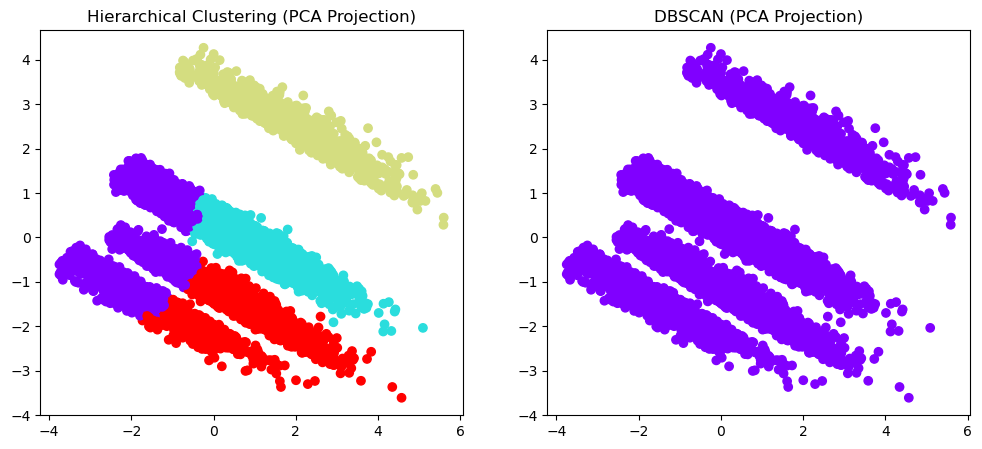

In [38]:
# Visualization Hierarchical vs DBSCAN
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].scatter(X_pca[:,0], X_pca[:,1], c=labels_hier, cmap="rainbow")
axes[0].set_title("Hierarchical Clustering (PCA Projection)")
axes[1].scatter(X_pca[:,0], X_pca[:,1], c=labels_db, cmap="rainbow")
axes[1].set_title("DBSCAN (PCA Projection)")
plt.show()


In [39]:
#  Agglomerative Clustering

agg = AgglomerativeClustering(n_clusters=2)
X['Agglomerative_Cluster'] = agg.fit_predict(X_pca)


In [40]:
scores= silhouette_score(X_pca, agg.labels_)
print("KMeans Silhouette Scores:", scores)

KMeans Silhouette Scores: 0.31783482994007883


In [41]:
from sklearn.metrics import silhouette_score
scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    scores[k] = silhouette_score(X_pca, km.labels_)
print(scores)

{2: 0.3302330763456669, 3: 0.24157216521326144, 4: 0.1868615570719374, 5: 0.15074783944626202, 6: 0.11777526317027509, 7: 0.09780068761085292, 8: 0.08165921604953846, 9: 0.06307664264280205, 10: 0.05313425910797382}


In [42]:
for eps in [0.3, 0.5, 0.7, 1.0]:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_scaled)
    if len(set(labels)) > 1:
        print(f"eps={eps} → score={silhouette_score(X_scaled, labels):.3f}")


eps=0.7 → score=-0.227
eps=1.0 → score=-0.406


## testing with drop one by one columns to see it will effect for increasing silhout score 

In [43]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# -------------------------------
# Step 1: Clean & encode dataset
# -------------------------------
df1 = df.copy()
df1 = df1.drop_duplicates()

# Drop unwanted columns
df1 = df1.drop(['ID','Age','Sleep_Hours','BMI','Caffeine_mg'], axis=1)

# Encode categorical variables
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                    'Health_Issues', 'Occupation']
for col in categorical_cols:
    df1[col] = LabelEncoder().fit_transform(df1[col])

# Scale numeric columns
num_cols = ['Coffee_Intake','Heart_Rate','Physical_Activity_Hours']
scaler = StandardScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols])

# -------------------------------
# Step 2: Variance Threshold
# -------------------------------
X_columns = df1.columns
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(df1)
selected_features = X_columns[selector.get_support(indices=True)]

X_reduced_df = pd.DataFrame(X_reduced, columns=selected_features)

print("Selected Features after VarianceThreshold:", list(selected_features))

# -------------------------------
# Step 3: Feature contribution test
# -------------------------------
for f in selected_features:
    X_temp = X_reduced_df.drop(columns=[f])
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X_temp)
    score = silhouette_score(X_temp, kmeans.labels_)
    print(f"Without {f}: {score:.3f}")


Selected Features after VarianceThreshold: ['Gender', 'Country', 'Coffee_Intake', 'Sleep_Quality', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption', 'Cluster']
Without Gender: 0.489
Without Country: 0.198
Without Coffee_Intake: 0.498
Without Sleep_Quality: 0.494
Without Heart_Rate: 0.498
Without Stress_Level: 0.488
Without Physical_Activity_Hours: 0.499
Without Health_Issues: 0.485
Without Occupation: 0.512
Without Smoking: 0.487
Without Alcohol_Consumption: 0.487
Without Cluster: 0.488


In [44]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

# -------------------------------
# Step 1: Preprocess data
# -------------------------------
df1 = df.copy()
df1 = df1.drop_duplicates()

# Drop unwanted columns
df1 = df1.drop(['ID','Age','Sleep_Hours','BMI','Caffeine_mg'], axis=1)

# Encode categorical variables (keep track of indices for KPrototypes)
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level',
                    'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption']

for col in categorical_cols:
    df1[col] = LabelEncoder().fit_transform(df1[col])

# Scale numeric columns
num_cols = ['Coffee_Intake','Heart_Rate','Physical_Activity_Hours']
scaler = StandardScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols])

# -------------------------------
# Step 2: Run KPrototypes
# -------------------------------
X = df1.values
cat_idx = [df1.columns.get_loc(col) for col in categorical_cols]  # categorical feature indices

kproto = KPrototypes(n_clusters=2, init='Huang', random_state=42, n_init=10)
clusters = kproto.fit_predict(X, categorical=cat_idx)

df1['Cluster'] = clusters

# -------------------------------
# Step 3: Evaluate
# -------------------------------
score = silhouette_score(X, clusters, metric='euclidean')
print("Silhouette Score (KPrototypes):", score)
print(df1.head())


Silhouette Score (KPrototypes): 0.035320949479388665
   Gender  Country  Coffee_Intake  Sleep_Quality  Heart_Rate  Stress_Level  \
0       1        7       0.683207              2    0.751563             1   
1       1        7      -1.040723              2   -0.368319             1   
2       1        2       1.924437              1   -1.182779             2   
3       1        7       0.062592              2    0.038911             1   
4       0       15       0.407378              1    0.547948             2   

   Physical_Activity_Hours  Health_Issues  Occupation  Smoking  \
0                 1.625265              0           2        0   
1                 0.814134              0           3        0   
2                 0.860485              0           1        0   
3                -0.205573              0           2        0   
4                 0.234755              0           4        0   

   Alcohol_Consumption  Cluster  
0                    0        1  
1            

The goal of this project was to segment individuals based on lifestyle and health indicators (such as caffeine intake, sleep quality, BMI, stress level, and physical activity) using unsupervised learning techniques. By identifying distinct clusters, we can better understand lifestyle patterns and their correlation with health outcomes